# Project 2: Implementing a Simple Convolutional Neural Network (CNN) using the Fashion-MNIST dataset

## Introduction

In this project, you will design, implement, and evaluate a simple Convolutional Neural Network (CNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- CIFAR-10: A dataset of 60,000 32x32 color images in 10 classes with 6,000 images per class.
- MNIST: A dataset of 70,000 28x28 grayscale images of handwritten digits (0-9).
- Fashion-MNIST: A dataset of 70,000 28x28 grayscale images of 10 different clothing caregories.


Required import

In [1]:
import torch
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

from torch.utils.tensorboard import SummaryWriter


1. Creating a data loader and implement data preprocessing

In [2]:
transform = transforms.Compose([transforms.ToTensor(), # Convert an image to tensor
                              transforms.Normalize((0.5,), (0.5,))]) # Normalize the images

# `64` strikes a balance between computational efficiency and generalization
batch_size = 64

# Download and load the training data using torch vision
trainset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

# Define the class labels for the Fashion MNIST dataset.
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

100%|██████████| 26421880/26421880 [00:03<00:00, 7998870.92it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 62331.80it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 481874.39it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6422450.03it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



2. Design a Convolutional Neural Network

In [3]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # `1` is the number of input channel for a black and white image
        # `16` is the number of output channels (hyperparameter)
        # `3` is the kernel size (3 * 3 pixels)
        # `1` is the padding added to the input image to ensure that the output feature map has the same spatial dimensions as the input
        # The images in FashionMNIST are 28 * 28
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)

        # `2` is the kernel size (2x2 pixels) of the pooling operation.
        # `2` is the stride of the pooling operation. It specifies the step size used to  slide the polling window other the input image.
        # Maz pooling reduces teh spatial dimensions of the input.
        self.pool = nn.MaxPool2d(2, 2)

        # `16*14*14` is the number of input channels which is the number of ouput channels in the previous layer multiplied by the spatial dimesntions of the feature map (14*14)
        # `14*14` as the spatial dimension allows for a balance between preserving spatial information and reducing the dimensionality of the data
        # `128` is the output size (hyperparameter)
        self.fc1 = nn.Linear(16 * 14 * 14, 128)

        # `128` is the number of neurons from the previous layer
        # `10` corresponds to the number of classes in the classification problem
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))

        #`view` is used to reshape the tensor
        # `-1` tells PyTorch to automatically infer the first dimension of the tensor which is the number of batch size used in the training parameters.
        # `16*14*14` is the number of input channels which must be equal to the number of output channels in the previous layer
        x = x.view(-1, 16 * 14 * 14)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

3. Train and evaluate the model

In [4]:
# Instantiate the model
model = Classifier()

In [5]:
# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Initialize TensorBoard
writer = SummaryWriter('runs/cifar10_experiment')

In [6]:
# Train the model
epochs = 2

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # It is used to zero out the gradients of all the parameters in the optimizer.
        # This is to avoid gradient accumulation from previous iterations which can lead to inaccurate updates to the model parameters.
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print

        if i % 200 == 199:  # every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}')
            writer.add_scalar('training loss',
                              running_loss / 2000,
                              epoch * len(trainloader) + i)
            running_loss = 0.0

print('Finished Training')

[1, 200] loss: 0.153
[1, 400] loss: 0.073
[1, 600] loss: 0.061
[1, 800] loss: 0.055
[2, 200] loss: 0.051
[2, 400] loss: 0.049
[2, 600] loss: 0.047
[2, 800] loss: 0.046
Finished Training


The loss value decreases as expected throughout the model training.

In [7]:
# Evaluate the model on the test data
correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

# Write the accuracy to TensorBoard
writer.add_scalar('accuracy',
                   100 * correct / total,
                   epoch * len(trainloader) + i)

writer.close()

Accuracy of the network on the test images: 83 %


Confusion Matrix: 


<Axes: >

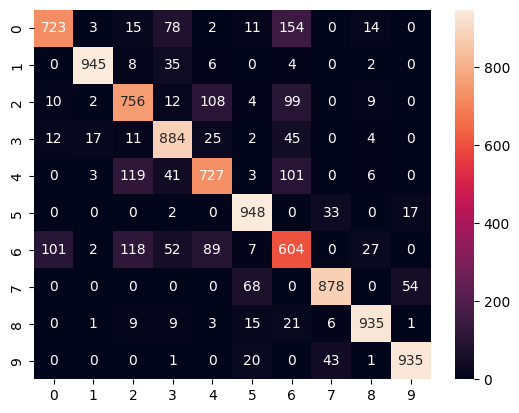

In [8]:
# Confusion metrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix: ")
sns.heatmap(cm, annot=True, fmt='d')

The confusion matrix shows that most labels have been predicted correclty.

GroundTruth:  Sandal Trouser Shirt  Coat
Predicted:  Sandal Pullover   Bag  Coat


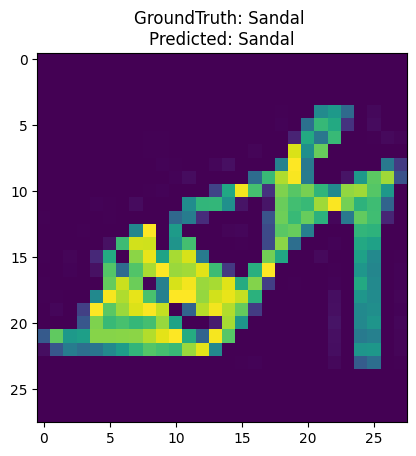

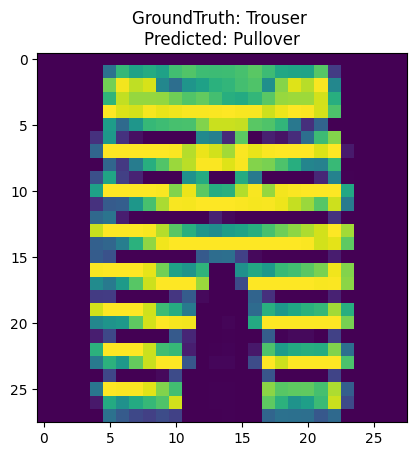

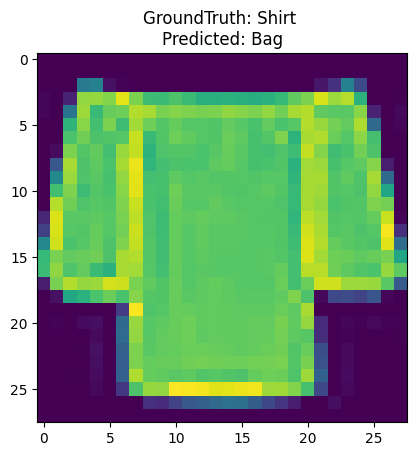

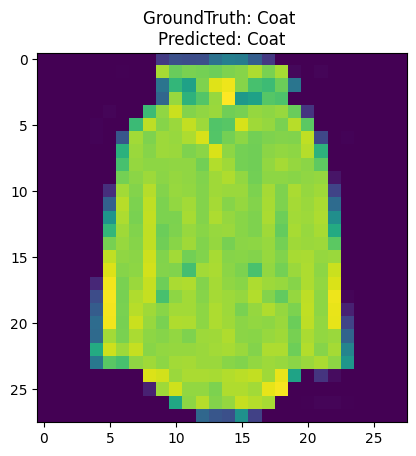

In [9]:
def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Visualize some of the predictions
dataiter = iter(testloader)
images, labels = next(dataiter)

# Print images with predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

# Show images with predictions
for i in range(4):
    imshow(images[i], f'GroundTruth: {classes[labels[i]]} \nPredicted: {classes[predicted[i]]}')

---
### Questions
Answer the following questions in detail.
1. What is a Convolutional Neural Network (CNN)? Describe its key components and how they differ from those in a fully connected neural network.
2. Explain the purpose of the convolution operation in a CNN. How does the use of different filter sizes affect the feature maps?
3. What is the purpose of a pooling layer in a CNN, and how does it contribute to the network’s performance?
4. Why are activation functions important in CNNs? Compare the use of ReLU (Rectified Linear Unit) with other activation functions.
5. Describe the process of training a CNN. What are some common challenges faced during training?
6. What are some common evaluation metrics used to assess the performance of a CNN on a classification task?
7. How does data augmentation help improve the performance of a CNN? Provide examples of common data augmentation techniques.



### Answers

1. A Convolutional Neural Network (CNN) is specific type of artificial neural network that uses perceptrons for surpervised learning [1]. It is a class of deep neural networks, most commonly applied to analyzing visual imagery. Examples of CNNs applications include image processing, natural language processing. The key components of a CNN are convolutional layers, activation functions, pooling layers, and fully connected layers. Convolutional layers perform convolution operations, applying filters to the input to create feature maps that summarize the presence of detected features in the input. Unlike in fully connected layers, neurons in a convolutional layer are only connected to a local region in the input, focusing on extracting local feature patterns. Activation functions introduce non-linearities into the model. Pooling layers perform down-sampling operations to reduce the spatial size  of the input volume for the next convolutional layer. Fully connected layers synthesize the features extracted by convolutional and pooling layers into predictions or classifications that are relevant to the task at hand. In a CNN, each neuron receives input from only a restricted area of the previous layer, typically a square, which is not the case for fully connected layers whose receptive field is the entire previous layer. [2] [3].

2. The convolution operation in a CNN is used in order to extract features from the input data [4]. In this operation, a filter of kernel is applied to the input data which results in a feature map. Different filter sizes can affect the feature map by determining the size of the region of the input that the filter covers. Larger filters result in larger receptive fileds and capture larger features, while smaller sizes capture more local features [5].

3. The pooling layer's main purpose is to reduce the spatial dimensions (width and height) of the input volume, while retaining the most important features. By reducing the spatial dimensions of the input volume, pooling layers decrease the number of parameters and computations needed in the network. Furthermore, the process of downsampling through pooling reduces the complexity of the model by abstracting the input features. Lastly, by summarizing the input features and making the network invariant to small translations, pooling layers help the model to generalize better from the training data to unseen data [6]

4. Activation functions are important in CNN because they introduce non-linearity into the network, allowing it to learn complex patterns. Moreover, activation functions help in deciding which features are important by determining whether a neuron should be activated or not. Then, certain activation functions such as ReLU support the backpropagation process and help mitigate the vanishing gradient problem, which can occur in deep networks. This ensures that gradients are not too small for effective learning during backpropagation. ReLU is widely used for its computational efficiency and effectiveness in deep learning models but has issues like the dying ReLU problem. Sigmoid and tanh are useful for certain tasks like binary classification and when outputs need to be normalized but suffer from the vanishing gradient problem. Leaky ReLU attempts to address some of ReLU's shortcomings while retaining its benefits, making it a useful alternative in many situations. [7][8]

5. Training a CNN involves collecting and preprocessing the data by performing operations such as resizing images to a uniform size, normalizing pizel values, and optionally augmenting the data. Then, defining the CNN Architecture, including the number and types of layers depending on the specific task. Next, initializing the weights and biases for the network. Then forward propagation where each layer performs its specific operation, and the final output is a prediciton made by the network. Next, calculating loss to quantify how far the network's precision is from the actual label. Then, backpropagation calculates the gradient of the loss function with respect to each weight and bias by propagating the error gradient backward through the network. Chain rule of calculus is used to iteratively adjust the weights and biases in a direction that minimally reduces the loss. Then, weights and biases are adjusted using an optimization algorithm such as SDG or Adam. The last 4 steps are iterated over the entire dataset multiple times so that the network weights are adjusted to minimize the loss. Some common challenges during training include overfitting (poor generalization), vanishing gradient problem during backprogation, and interpretability (black box).

6. Common evaluation metrics used to assess the performance of a CNN on a classification task include: accuracy, precision, recall, F1 score, confusion matrix, ROC, AUC, etc.

7. Data augmentation increases the diversity of the training data without collecting new data, and help the a CNN model generalize better to unseen data. By artificially increasing the size of the training dataset through modifications, data augmentation helps prevent the model from overfitting. Moreover, data augmentation techniques can help a CNN learn to be invariant to certain transformations.Some common data augmentation techniques include various forms of transformations, such as rotations, translations, zooming, flipping, cropping, rescaling, color jittering, noise injection, etc.

References:

[1] Rouse, M. (2023) Convolutional Neural Network. Available at: https://www.techopedia.com/definition/32731/convolutional-neural-network-cnn

[2] BIG VISION (2024) Convolutional Neural Network (CNN): A Complete Guide. Available at: https://learnopencv.com/understanding-convolutional-neural-networks-cnn/

[3] Wikipedia (2024) Convolutional neural network. Available at: https://en.wikipedia.org/wiki/Convolutional_neural_network

[4] Choudhari, P. (2020) Understanding “convolution” operations in CNN. Available at: https://medium.com/analytics-vidhya/understanding-convolution-operations-in-cnn-1914045816d4

[5] Pandey, S. (2020) How to choose the size of the convolution filter or Kernel size for CNN? Available at: https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15

[6] GeeksForGeeks (2023) CNN | Introduction to Pooling Layer. Available at: https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/

[7] GeeksForGeeks (2024) Activation functions in Neural Networks. Available at: https://www.geeksforgeeks.org/activation-functions-neural-networks/

[8] Machine Learning in Plain English (2023) Convolutional Neural Network — Lesson 9: Activation Functions in CNNs. Available at: https://medium.com/@nerdjock/convolutional-neural-network-lesson-9-activation-functions-in-cnns-57def9c6e759

---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.